# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 139 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 216 kB 28.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 81.4 MB/s eta 0:00:01


**Important: Restart the Kernel at this moment**

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [6]:
!pip install -q IProgress tqdm

In [8]:
!pip install -q ipywidgets==7.6.3
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Create training set and define training dataloader
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True
)

# Create test set and define test dataloader
test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=1000, 
    shuffle=False
)

Failed to download (trying next):
HTTP Error 404: Not Found




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I chose these transforms for the following reasons:

1. **ToTensor()**: Converts the PIL image to a PyTorch tensor and scales the pixel values from [0, 255] to [0, 1].

2. **Normalize((0.1307,), (0.3081,))**: These values represent the mean and standard deviation of the MNIST dataset. Normalizing the data helps the network converge faster during training by centering the data around zero with a standard deviation of 1. This is a standard practice that makes the optimization process more stable and efficient.

Normalization is particularly important for neural networks as it helps prevent issues like vanishing/exploding gradients and ensures all features contribute equally to the learning process.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Training dataset size: 60000
Test dataset size: 10000
Image shape: torch.Size([1, 28, 28])
Target class: 5


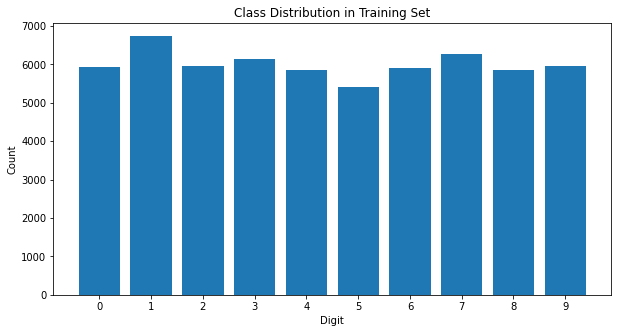

6


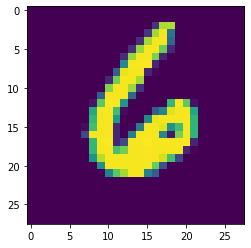

9


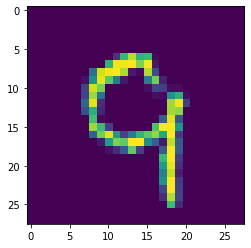

8


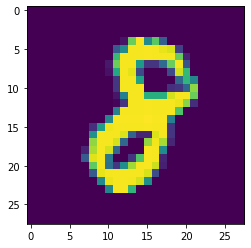

1


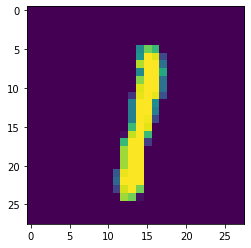

8


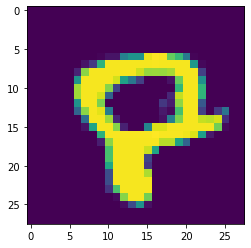

In [4]:
# Explore data
# Explore data
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Check the shape of a single image
data_sample, target_sample = train_dataset[0]
print(f"Image shape: {data_sample.shape}")
print(f"Target class: {target_sample}")

# Class distribution in training set
class_counts = [0] * 10
for _, label in train_dataset:
    class_counts[label] += 1
    
plt.figure(figsize=(10, 5))
plt.bar(range(10), class_counts)
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Class Distribution in Training Set')
plt.xticks(range(10))
plt.show()

# Show 5 sample images
# Create a dataloader with no normalization for better visualization
transform_viz = transforms.Compose([transforms.ToTensor()])
viz_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_viz)
viz_loader = torch.utils.data.DataLoader(viz_dataset, batch_size=64, shuffle=True)

show5(viz_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [14]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2)
        # Dropout for regularization
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        
        # For MNIST (28x28 images), after one pooling layer (28/2 = 14x14)
        # The feature map size will be 64 x 14 x 14 = 12544
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        # Second block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected part
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        # Output with log_softmax for NLLLoss
        return F.log_softmax(x, dim=1)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [15]:
# Instantiate the model
model = MNISTNet()

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.NLLLoss()  # Negative log likelihood loss works well with log_softmax
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [16]:
# Training parameters
num_epochs = 10
train_losses = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track the loss
        running_loss += loss.item()
        
        # Print statistics every 100 batches
        if batch_idx % 100 == 99:
            print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {running_loss/100:.4f}')
            running_loss = 0.0
    
    # Calculate average training loss for the epoch
    model.eval()  # Set model to evaluation mode
    epoch_loss = 0.0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    accuracy = 100. * correct / len(test_dataset)
    test_accuracies.append(accuracy)
    
    print(f'Epoch: {epoch+1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print('-' * 40)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1/10, Batch: 100/938, Loss: 1.5498
Epoch: 1/10, Batch: 200/938, Loss: 1.3005
Epoch: 1/10, Batch: 300/938, Loss: 1.2372
Epoch: 1/10, Batch: 400/938, Loss: 1.2329
Epoch: 1/10, Batch: 500/938, Loss: 1.2177
Epoch: 1/10, Batch: 600/938, Loss: 1.2087
Epoch: 1/10, Batch: 700/938, Loss: 1.2427
Epoch: 1/10, Batch: 800/938, Loss: 1.2036
Epoch: 1/10, Batch: 900/938, Loss: 1.2131
Epoch: 1/10
Training Loss: 0.1199
Test Loss: 0.1142
Test Accuracy: 97.64%
----------------------------------------
Epoch: 2/10, Batch: 100/938, Loss: 1.2263
Epoch: 2/10, Batch: 200/938, Loss: 1.1925
Epoch: 2/10, Batch: 300/938, Loss: 1.1916
Epoch: 2/10, Batch: 400/938, Loss: 1.1845
Epoch: 2/10, Batch: 500/938, Loss: 1.1899
Epoch: 2/10, Batch: 600/938, Loss: 1.1762
Epoch: 2/10, Batch: 700/938, Loss: 1.1848
Epoch: 2/10, Batch: 800/938, Loss: 1.1782
Epoch: 2/10, Batch: 900/938, Loss: 1.2104
Epoch: 2/10
Training Loss: 0.0976
Test Loss: 0.0974
Test Accuracy: 98.30%
----------------------------------------
Epoch: 3/10, B

Plot the training loss (and validation loss/accuracy, if recorded).

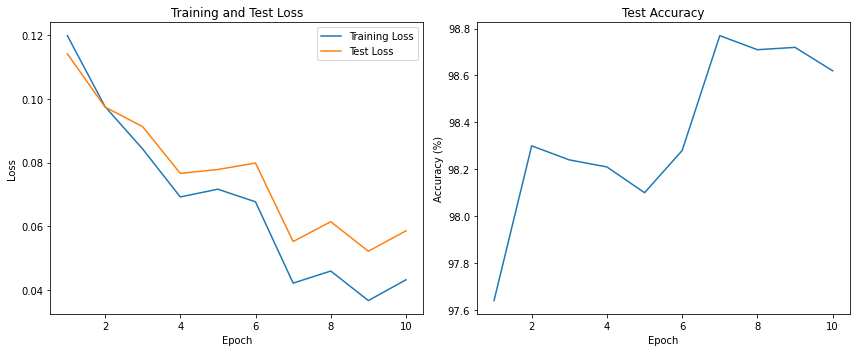

In [17]:
# Plot training and test loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')

plt.tight_layout()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

Test Loss: 0.0585
Test Accuracy: 98.62%


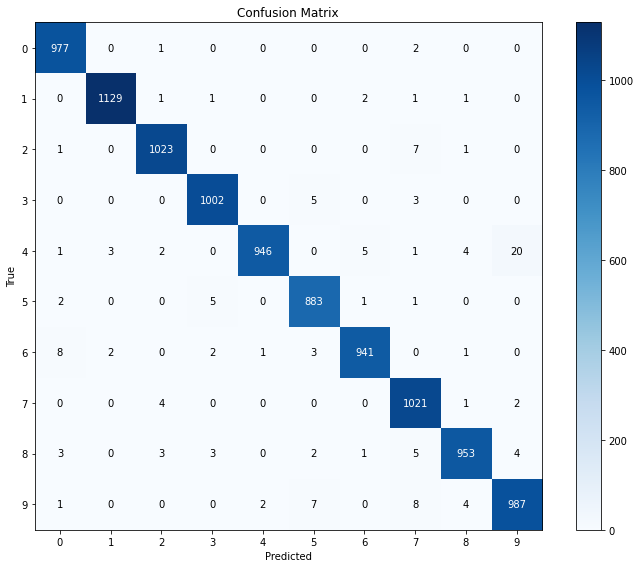

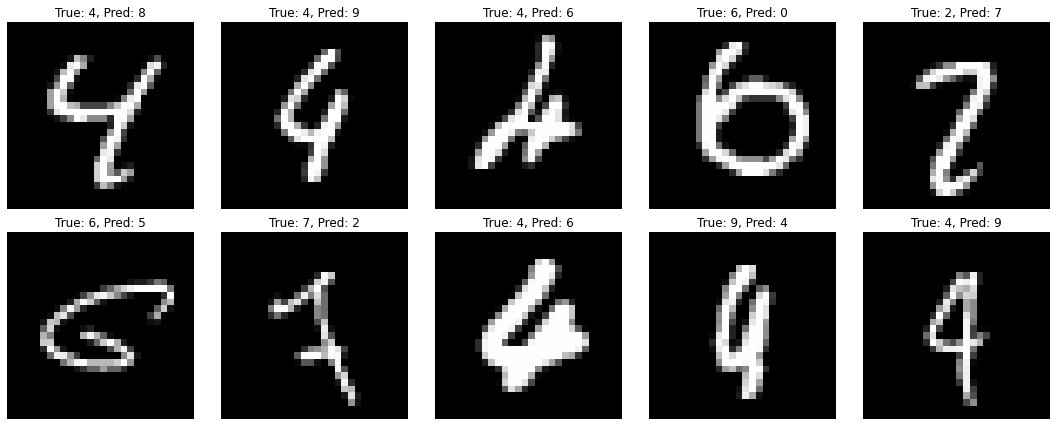

In [18]:
# Test the model
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader)
accuracy = 100. * correct / len(test_dataset)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')

# Create a confusion matrix
confusion_matrix = torch.zeros(10, 10, dtype=torch.int)
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        for t, p in zip(target.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(range(10))
plt.yticks(range(10))

# Add text annotations
for i in range(10):
    for j in range(10):
        plt.text(j, i, confusion_matrix[i, j].item(), 
                 ha="center", va="center", 
                 color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black")

plt.tight_layout()
plt.show()

# Display some misclassified examples
model.eval()
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        
        # Find indices where predictions are wrong
        incorrect_mask = pred.ne(target)
        if incorrect_mask.any():
            misclassified_indices = incorrect_mask.nonzero(as_tuple=True)[0]
            for idx in misclassified_indices[:5]:  # Get up to 5 misclassified examples
                if len(misclassified_images) < 10:  # Limit to 10 examples total
                    misclassified_images.append(data[idx].cpu())
                    misclassified_labels.append(target[idx].item())
                    misclassified_preds.append(pred[idx].item())

# Display misclassified examples
if misclassified_images:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, (img, true_label, pred_label) in enumerate(zip(misclassified_images, misclassified_labels, misclassified_preds)):
        if i < 10:
            axes[i].imshow(img.squeeze(), cmap='gray')
            axes[i].set_title(f'True: {true_label}, Pred: {pred_label}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
# Define an improved model with more capacity
class ImprovedMNISTNet(nn.Module):
    def __init__(self):
        super(ImprovedMNISTNet, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(0.2)
        
        # Second convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(0.3)
        
        # Fully connected layers
        # MNIST is 28x28, after two pooling layers (28/2/2 = 7x7)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout3 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Flatten for fully connected layers
        x = torch.flatten(x, 1)
        
        # Fully connected part
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the improved model and move it to the correct device
improved_model = ImprovedMNISTNet().to(device)

# Define loss function (already defined earlier)
# criterion = nn.NLLLoss()  # Uncomment if not already defined

# Define optimizer with learning rate scheduler
improved_optimizer = optim.Adam(improved_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(improved_optimizer, 'min', patience=2, factor=0.5, verbose=True)

# Training parameters
num_epochs = 15
improved_train_losses = []
improved_test_losses = []
improved_test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    improved_model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Zero the parameter gradients
        improved_optimizer.zero_grad()
        
        # Forward pass
        output = improved_model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimize
        loss.backward()
        improved_optimizer.step()
        
        # Track the loss
        running_loss += loss.item()
        
        # Print statistics every 100 batches
        if batch_idx % 100 == 99:
            print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {running_loss/100:.4f}')
            running_loss = 0.0
    
    # Calculate average training loss for the epoch
    improved_model.eval()  # Set model to evaluation mode
    epoch_loss = 0.0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = improved_model(data)
            loss = criterion(output, target)
            epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    improved_train_losses.append(avg_train_loss)
    
    # Evaluate on test set
    improved_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = improved_model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader)
    improved_test_losses.append(test_loss)
    
    # Update learning rate scheduler
    scheduler.step(test_loss)
    
    accuracy = 100. * correct / len(test_dataset)
    improved_test_accuracies.append(accuracy)
    
    print(f'Epoch: {epoch+1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print('-' * 40)

# Plot training and test loss for improved model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), improved_train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), improved_test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Improved Model: Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), improved_test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Improved Model: Test Accuracy')

plt.tight_layout()
plt.show()

# Final test for improved model
improved_model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = improved_model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader)
accuracy = 100. * correct / len(test_dataset)

print(f'Final Improved Model Test Loss: {test_loss:.4f}')
print(f'Final Improved Model Test Accuracy: {accuracy:.2f}%')

Using device: cuda
Epoch: 1/15, Batch: 100/938, Loss: 0.7656
Epoch: 1/15, Batch: 200/938, Loss: 0.2424
Epoch: 1/15, Batch: 300/938, Loss: 0.1645
Epoch: 1/15, Batch: 400/938, Loss: 0.1498
Epoch: 1/15, Batch: 500/938, Loss: 0.1404
Epoch: 1/15, Batch: 600/938, Loss: 0.1401
Epoch: 1/15, Batch: 700/938, Loss: 0.1368
Epoch: 1/15, Batch: 800/938, Loss: 0.1222
Epoch: 1/15, Batch: 900/938, Loss: 0.1037
Epoch: 1/15
Training Loss: 0.0435
Test Loss: 0.0349
Test Accuracy: 98.73%
----------------------------------------
Epoch: 2/15, Batch: 100/938, Loss: 0.1032
Epoch: 2/15, Batch: 200/938, Loss: 0.0918
Epoch: 2/15, Batch: 300/938, Loss: 0.0910
Epoch: 2/15, Batch: 400/938, Loss: 0.1058
Epoch: 2/15, Batch: 500/938, Loss: 0.0816
Epoch: 2/15, Batch: 600/938, Loss: 0.0812
Epoch: 2/15, Batch: 700/938, Loss: 0.1028
Epoch: 2/15, Batch: 800/938, Loss: 0.0830
Epoch: 2/15, Batch: 900/938, Loss: 0.0806
Epoch: 2/15
Training Loss: 0.0406
Test Loss: 0.0379
Test Accuracy: 98.72%
------------------------------------

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
# Save the improved model
torch.save(improved_model.state_dict(), 'mnist_improved_model.pth')
print("Model saved successfully.")

# Save the entire model (including architecture)
torch.save(improved_model, 'mnist_improved_model_full.pth')
print("Full model saved successfully.")

# To load the model later:
# Option 1: Load state dict (requires model class definition)
# loaded_model = ImprovedMNISTNet()
# loaded_model.load_state_dict(torch.load('mnist_improved_model.pth'))

# Option 2: Load full model
# loaded_model = torch.load('mnist_improved_model_full.pth')